In [1]:
from ultralytics import YOLO

from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image

import chess

import cv2

from shapely.geometry import Polygon
from roboflow import Roboflow


In [2]:
rf = Roboflow(api_key="Yr1jfwkQBJcCCKmwpgwI")
project1 = rf.workspace().project("chess-corners-wzsil")
model_board = project1.version(1).model


loading Roboflow workspace...
loading Roboflow project...


In [3]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [4]:
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [5]:
def detect_corners(image):
    mod = model_board.predict(image, confidence=30, overlap=30).json()
    boxes = np.array([0, 0])

    #stop after 4 corners are detected
    for bounding_box in mod['predictions']:
        x = bounding_box['x']
        y = bounding_box['y']
        box = np.array([x, y])
        boxes = np.vstack((boxes, box))
        if len(boxes) == 5:
            break


    '''for bounding_box in mod['predictions']:
        x = bounding_box['x']
        y = bounding_box['y']
        box = np.array([x, y])
        boxes = np.vstack((boxes, box))'''

    #remove the first row of zeros
    boxes = np.delete(boxes, 0, 0)
    print(boxes)
    return boxes

In [6]:
def four_point_transform(image, pts):
      
    img = Image.open(image)
    image = asarray(img)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
   

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    #img.show()    
    # return the warped image
    return img



In [7]:
def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [8]:
def chess_pieces_detector(image):
    
    model_trained = YOLO(r"C:\Users\heetm\OneDrive\Desktop\DL Assignment\Code\Chess-Board-and-Piece-Detection\pieces.pt")
    results = model_trained.predict(source=image,save=True)
    
    boxes = results[0].boxes
    detections = boxes.xyxy.numpy()
    
    return detections, boxes

In [9]:
def connect_square_to_detection(detections, square):
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q',5: 'r', 6: 'board', 
      7: 'B', 8: 'K', 9: 'N',
      10: 'P', 11: 'Q', 12: 'R'}

    list_of_iou=[]
    
    for i in detections:

        box_x1 = i[0]
        box_y1 = i[1]

        box_x2 = i[2]
        box_y2 = i[1]

        box_x3 = i[2]
        box_y3 = i[3]

        box_x4 = i[0]
        box_y4 = i[3]
        
        #cut high pieces        
        if box_y4 - box_y1 > 60:
            box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
        else:
            box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
            
        #until here

        list_of_iou.append(calculate_iou(box_complete, square))
        #print(list_of_iou)

    num = list_of_iou.index(max(list_of_iou))

    piece = boxes.cls[num].tolist()
    
    if max(list_of_iou) > 0.10:
        piece = boxes.cls[num].tolist()
        #print(piece)
        if piece == 6:
            piece = "empty"
            return piece
        else:
            return di[piece]
    
    else:
        piece = "empty"
        return piece

[[1085  381]
 [1113 1329]
 [ 114 1370]
 [ 131  395]]

0: 640x640 1 black-bishop, 1 black-king, 2 black-pawns, 1 black-queen, 1 black-rook, 1 board, 1 white-bishop, 1 white-king, 1 white-knight, 2 white-pawns, 1 white-queen, 1 white-rook, 251.5ms
Speed: 5.0ms preprocess, 251.5ms inference, 775.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict24


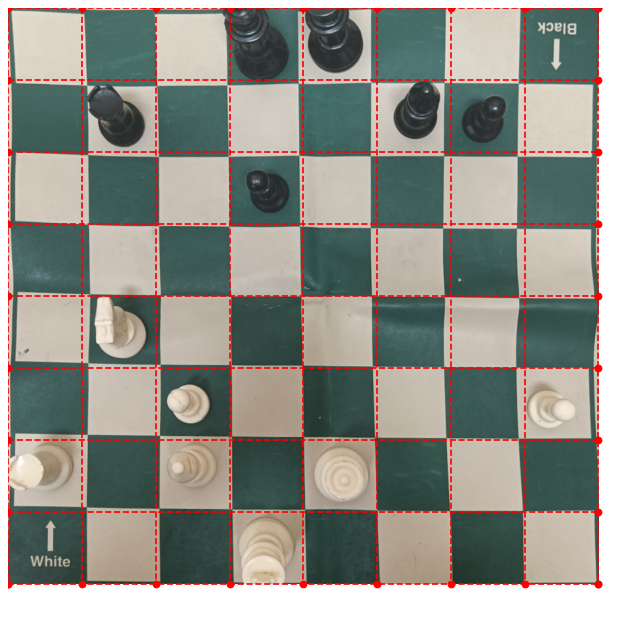

In [10]:
image = r"C:\Users\heetm\OneDrive\Desktop\DL Assignment\Code\Chess-Board-and-Piece-Detection\test_images\test5.jpg"

corners = detect_corners(image)

transformed_image = four_point_transform(image, corners)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)

detections, boxes = chess_pieces_detector(transformed_image)

111qk111/1r111bp1/111p1111/11111111/1N111111/11P1111P/R1B1Q111/111K1111
3qk3/1r3bp1/3p4/8/1N6/2P4P/R1B1Q3/3K4 b


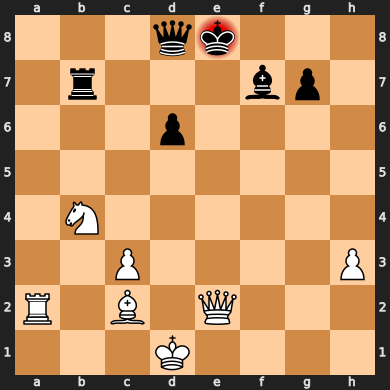

In [26]:
xA = ptsT[0][0]
xB = ptsT[1][0]
xC = ptsT[2][0]
xD = ptsT[3][0]
xE = ptsT[4][0]
xF = ptsT[5][0]
xG = ptsT[6][0]
xH = ptsT[7][0]
xI = ptsT[8][0]

y9 = ptsL[0][1]
y8 = ptsL[1][1] 
y7 = ptsL[2][1] 
y6 = ptsL[3][1]  
y5 = ptsL[4][1]  
y4 = ptsL[5][1] 
y3 = ptsL[6][1]  
y2 = ptsL[7][1] 
y1 = ptsL[8][1] 

#calculate all the squares

a8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
a7 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
a6 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
a5 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
a4 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
a3 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
a2 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
a1 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])

b8 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
b7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
b6 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
b5 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
b4 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
b3 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
b2 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
b1 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])

c8 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
c7 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
c6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
c5 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
c4 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
c3 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
c2 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
c1 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])

d8 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
d7 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
d6 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
d5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
d4 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
d3 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
d2 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
d1 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])

e8 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
e7 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
e6 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
e5 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
e4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
e3 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
e2 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
e1 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])

f8 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
f7 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
f6 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
f5 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
f4 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
f3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
f2 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
f1 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])

g8 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
g7 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
g6 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
g5 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
g4 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
g3 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
g2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
g1 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])

h8 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
h7 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
h6 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
h5 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
h4 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
h3 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
h2 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
h1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])

# transforms the squares to write FEN

FEN_annotation = [[a8, b8, c8, d8, e8, f8, g8, h8],
                [a7, b7, c7, d7, e7, f7, g7, h7],
                [a6, b6, c6, d6, e6, f6, g6, h6],
                [a5, b5, c5, d5, e5, f5, g5, h5],
                [a4, b4, c4, d4, e4, f4, g4, h4],
                [a3, b3, c3, d3, e3, f3, g3, h3],
                [a2, b2, c2, d2, e2, f2, g2, h2],
                [a1, b1, c1, d1, e1, f1, g1, h1]]

board_FEN = []
corrected_FEN = []
complete_board_FEN = []

for line in FEN_annotation:
    line_to_FEN = []
    for square in line:
        piece_on_square = connect_square_to_detection(detections, square)    
        line_to_FEN.append(piece_on_square)
    corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
    #print(corrected_FEN)
    board_FEN.append(corrected_FEN)

complete_board_FEN = [''.join(line) for line in board_FEN] 

to_FEN = '/'.join(complete_board_FEN)
print(to_FEN)

# Replace consecutive digits with the count of those digits
converted_fen = ''
for row in to_FEN.split('/'):
    converted_row = ''
    count = 0
    for char in row:
        if char.isdigit():
            count += int(char)
        else:
            if count > 0:
                converted_row += str(count)
                count = 0
            converted_row += char
    if count > 0:
        converted_row += str(count)
    converted_fen += converted_row + '/'
    
# Remove trailing '/'
converted_fen = converted_fen.rstrip('/')
converted_fen = converted_fen + ' b'
print(converted_fen)

chess.Board(converted_fen)



Score: PovScore(Cp(-413), BLACK)
Next move: e8f8


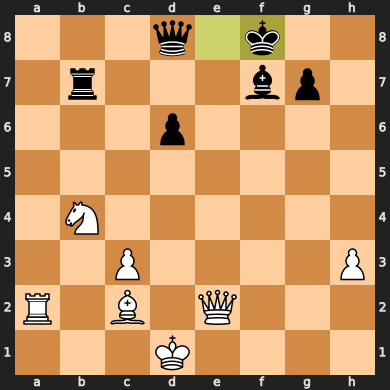

In [30]:
#precict the next move and play using stockfish
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci(r"C:\Users\heetm\OneDrive\Desktop\DL Assignment\Code\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")

board = chess.Board(converted_fen)

info = engine.analyse(board, chess.engine.Limit(time=0.1))

print("Score:", info["score"])
print("Next move:", info["pv"][0])

board.push(info["pv"][0])

engine.quit()

board